## Read space-time dataset 

A space-time matrix is a structure with time series of observed displacements. The current files has been produced in Matlab. In Python we can read this dataset and store the contents in a dictionary

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pygmt
import xarray as xr
import os
import statsmodels.api as sm
from scipy import linalg
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy import signal
from scipy.stats.distributions import chi2

In [2]:
stm = scipy.io.loadmat('06gps_nam_2006-2024.mat')

In [3]:
stm.keys()

dict_keys(['__header__', '__version__', '__globals__', 'datasetId', 'techniqueId', 'datasetAttrib', 'techniqueAttrib', 'numPoints', 'numEpochs', 'pntName', 'pntCrd', 'pntAttrib', 'epochDyear', 'epochAttrib', 'parTypes', 'obsTypes', 'auxTypes', 'obsData', 'auxData', 'sensitivityMatrix', 'stochModel', 'stochData', 'inputDatasets', 'globalAttrib'])

## Point names and coordinates, epoch times and observations types

The displacement timeseries are stored in the field with key 'obsData'. The displacements are stored as a three dimensional matrix. The first dimension (rows) are for the points, the second dimension (columns) is for the epochs, and the third dimension (pages) is for different observation types.

The point names and geographic coordinates (Latitude, Longitude, Height above ellipsoid) are stored in the fields with keys 'pntName' and 'pntCrd'.  The epoch times - in decimal years - are stored in the field with key 'epochDyear', and observation types in the field with key 'obsTypes'.

In [4]:
pntName=stm['pntName']
pntCrd=stm['pntCrd']
epochDyear=stm['epochDyear'][0]
obsTypes=stm['obsTypes']

obsData=stm['obsData']

In [55]:
# track = 's1_asc_t088'
# path = os.path.join('/Users/isabelslingerland/master AES/year 1/Q4/Lab/AESM402B Earth Observation B-module (202324 Q4) - 5222024 - 350 PM/', track) 
# netcdf_file = os.path.join('/Users/isabelslingerland/master AES/year 1/Q4/Lab/AESM402B Earth Observation B-module (202324 Q4) - 5222024 - 350 PM/', ("%s_v2.nc" % track))
# s1_stack = xr.load_dataset(netcdf_file,engine="h5netcdf")


In [56]:
# insarlon= s1_stack.lon
# print(np.min(insarlon), np.max(insarlon))

<xarray.DataArray 'lon' ()>
array(6.4137645, dtype=float32) <xarray.DataArray 'lon' ()>
array(6.466585, dtype=float32)


In [5]:
lonmin = np.min(pntCrd[:,1])
lonmax = np.max(pntCrd[:,1])
latmin = np.min(pntCrd[:,0])
latmax = np.max(pntCrd[:,0])

In [6]:
# Filtering data based on latitude and longitude conditions
filtered_data = pntCrd[(pntCrd[:,0] >= 53.12422943) & (pntCrd[:,0] <= 53.15570068) &
                             (pntCrd[:,1] >= 6.41376448) & (pntCrd[:,1]<= 6.46658516)]

# # Extracting names from the first column for the filtered data
# station_names_in_region = pntName[li]
# print(station_names_in_region.size)
print(filtered_data)

print(np.where(pntCrd==filtered_data))
print(f'GNSS station in our are Insar area {pntName[43]}')

[[53.13637818  6.44928672 45.61663657]]
(array([43, 43, 43]), array([0, 1, 2]))
GNSS station in our are Insar area [array(['RDN1'], dtype='<U4')]


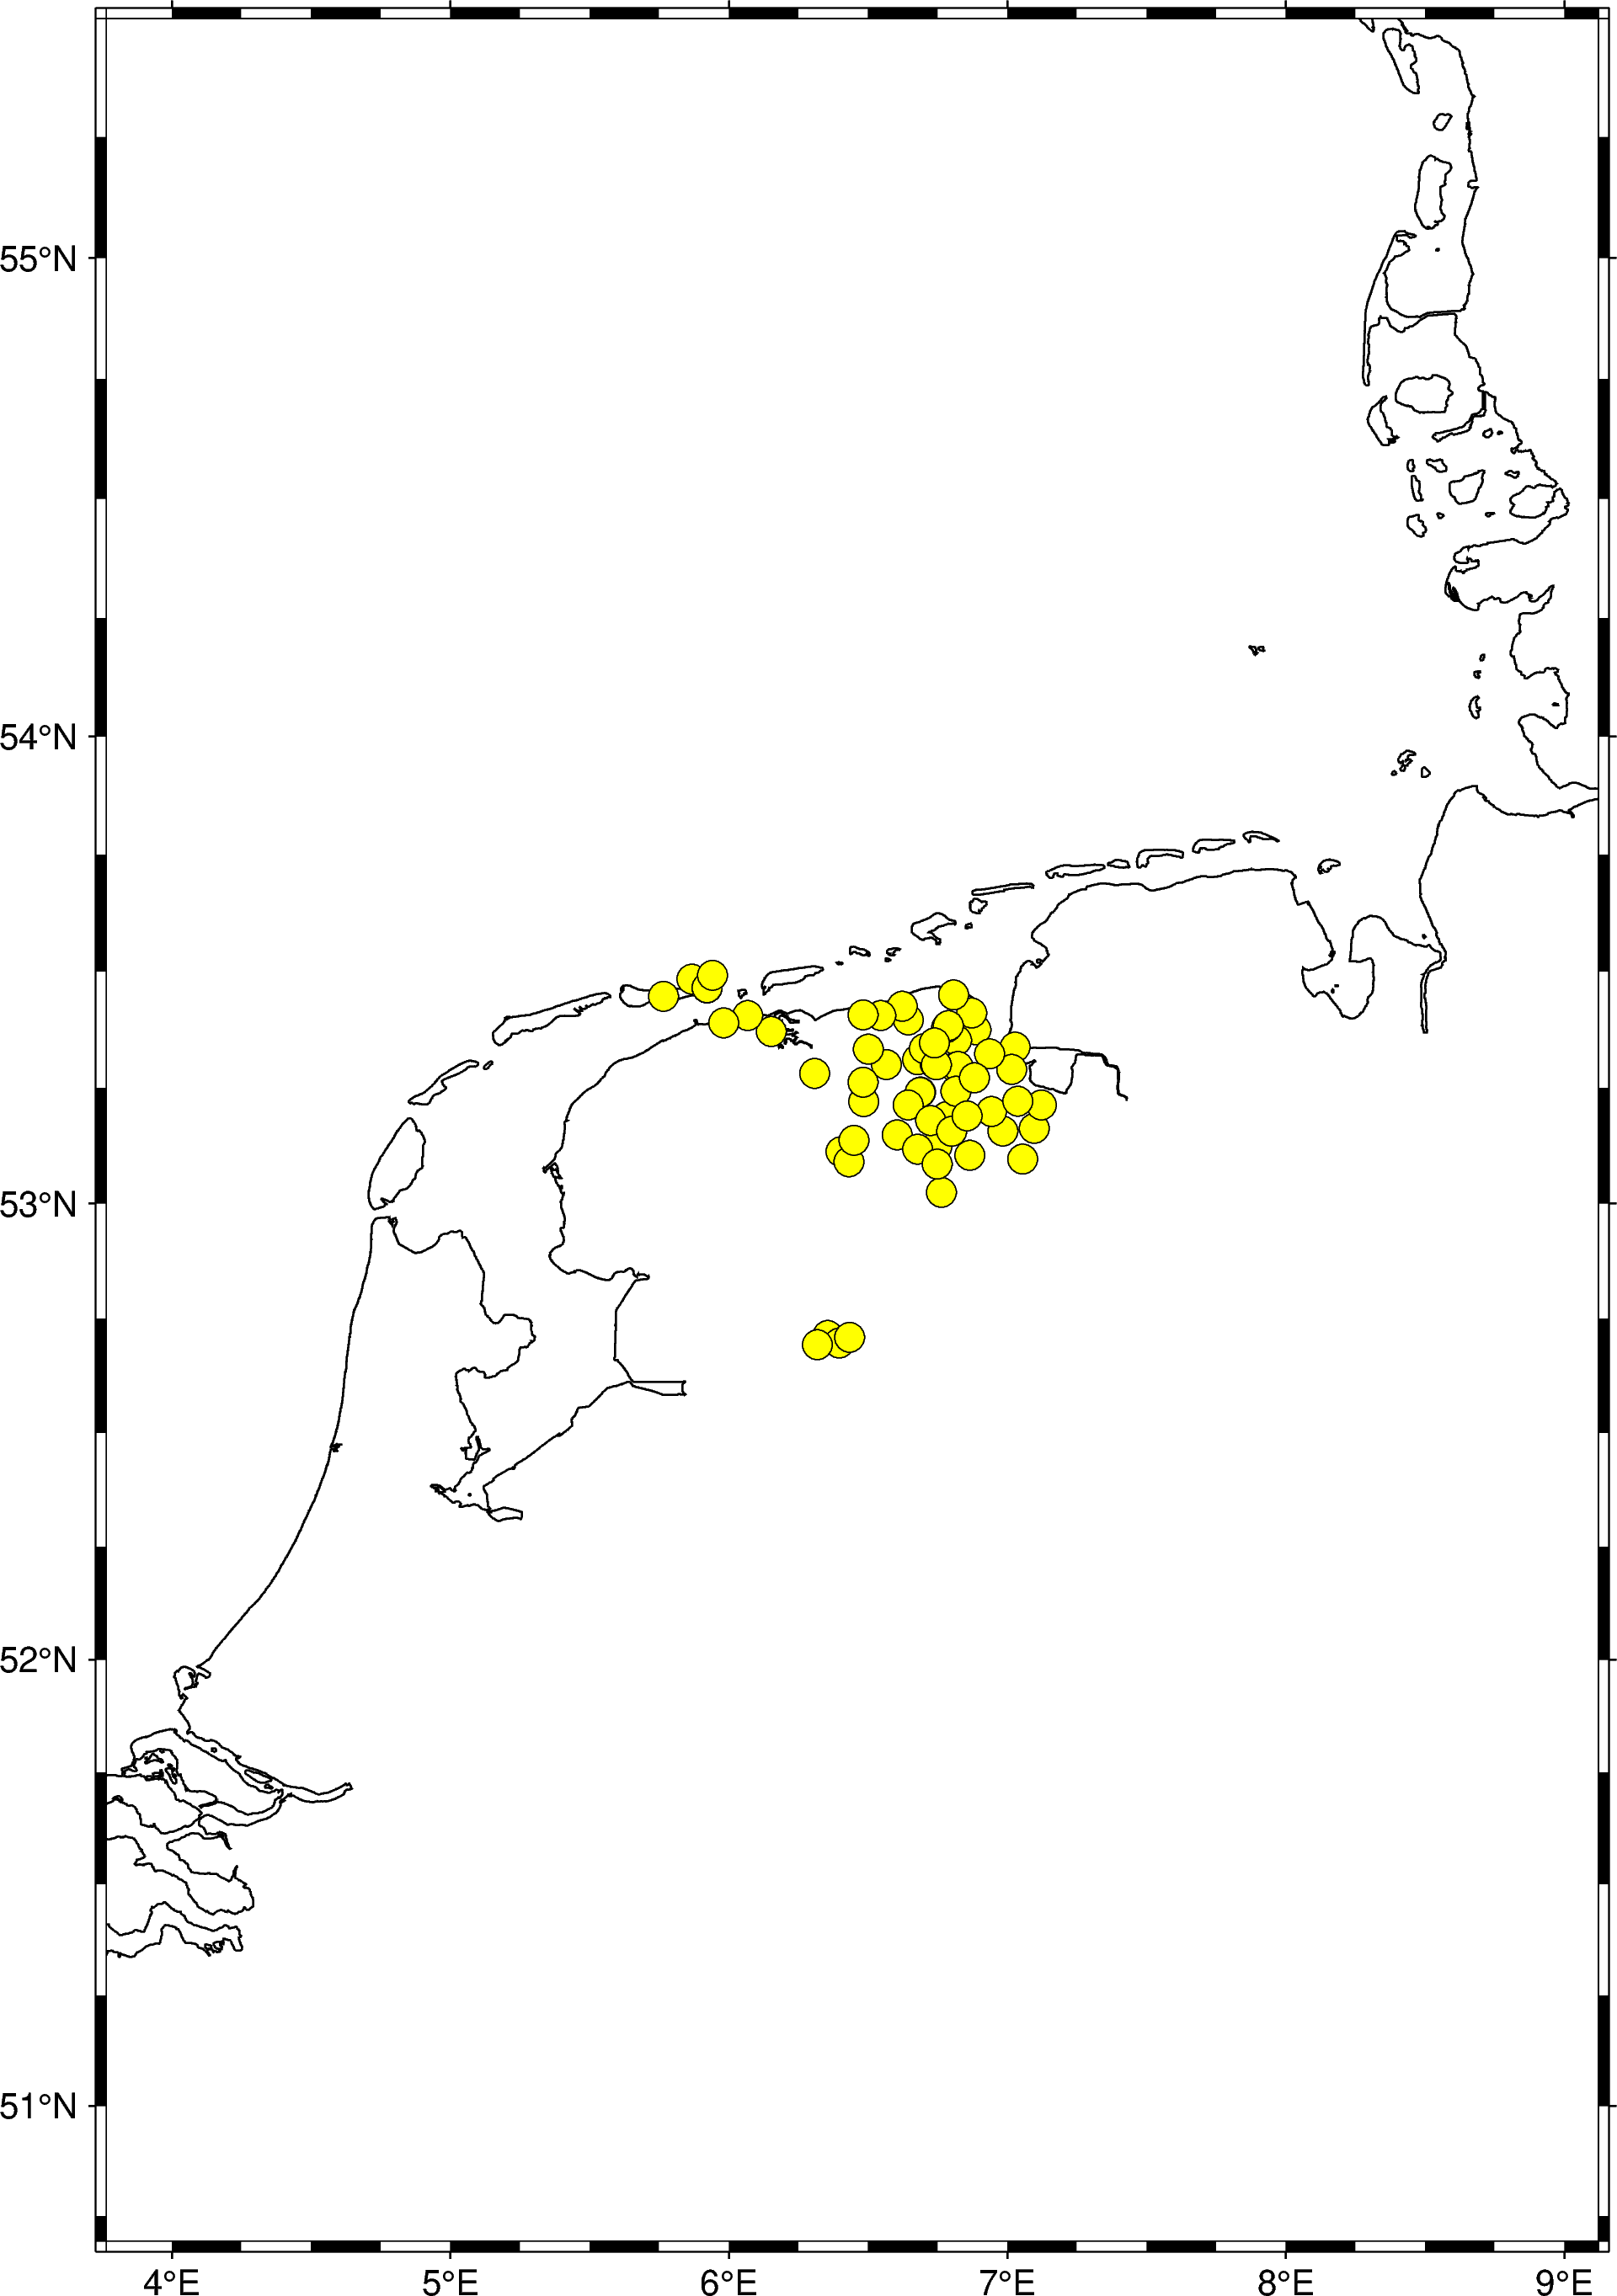

In [8]:
#plot map with GNSS stations




region = [
    lonmin-2,
    lonmax+2,
    latmin-2,
    latmax+2,
]

fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame=True)
fig.coast(shorelines="1/0.5p,black")
fig.plot(x= pntCrd[:,1],y= pntCrd[:,0], style="c0.3c", fill="yellow", pen="black")
fig.show()


For convenience we convert the array with point names and observation types to a list

In [9]:
pntList= [ pntName[x][0][0] for x in np.arange(0,pntName.shape[0]) ]
obsList= [ obsTypes[0][x][0] for x in np.arange(0,obsTypes.shape[1]) ]

In [10]:
print(pntList)

['0647', 'AME1', 'AME2', 'AME3', 'AME4', 'AMEL', 'ANJM', 'AWG1', 'BARN', 'BEDU', 'BEER', 'BIER', 'BLIJ', 'BORG', 'D200', 'DW16', 'DW26', 'DZY1', 'EEM2', 'EEMS', 'EEXT', 'EMSH', 'ENGE', 'FROO', 'GANZ', 'GRIJ', 'GRON', 'HARE', 'HEIL', 'HOO9', 'KOLH', 'LEER', 'MIDL', 'MODD', 'NOR3', 'NORG', 'NSCH', 'OLDO', 'OOSW', 'OVE2', 'OVER', 'POST', 'RANU', 'RDN1', 'SAPP', 'SCHW', 'STED', 'STIL', 'TENA', 'TENP', 'TERN', 'TJUC', 'UITH', 'USQU', 'VEEN', 'WARF', 'WTNL', 'ZAN2', 'ZAND', 'ZDVN', 'ZEER', 'ZLDV']


In [11]:
print(epochDyear)

[2006.40109514 2006.40383299 2006.40657084 ... 2024.00821355 2024.0109514
 2024.01368925]


In [12]:
print(obsList)

['North', 'East', 'Up']


In [13]:
print('obsData.shape', obsData.shape)
print('len(pntList)', len(pntList))
print('epochDyear.shape', epochDyear.shape)

obsData.shape (62, 6434, 3)
len(pntList) 62
epochDyear.shape (6434,)


## Finding the time series for a station

To obtain the time series for - for instance - the up component of NORG you can do this

In [14]:
pnum=pntList.index('RDN1')
updisplacements=obsData[pnum,:,2]
northdisplacements=obsData[pnum,:,0]
eastdisplacements=obsData[pnum,:,1]
print(epochDyear)

[2006.40109514 2006.40383299 2006.40657084 ... 2024.00821355 2024.0109514
 2024.01368925]


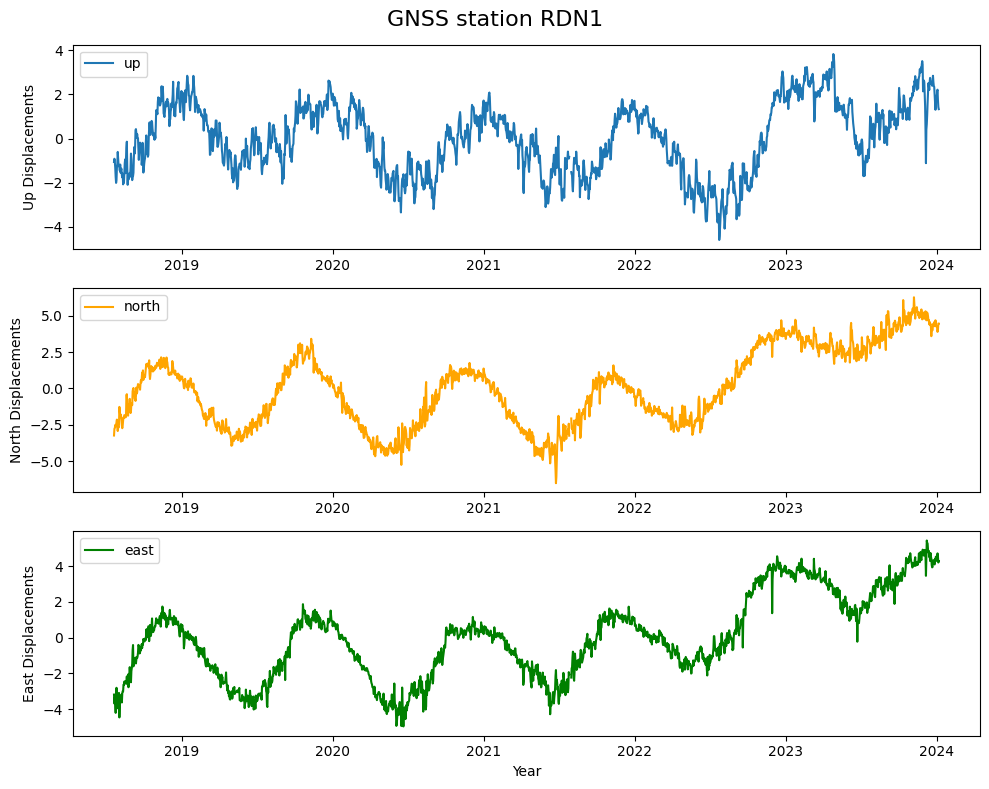

In [15]:
# Creating the subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Plotting the up displacements
axs[0].plot(epochDyear, updisplacements, label='up')
axs[0].set_ylabel('Up Displacements')
axs[0].legend()

# Plotting the north displacements
axs[1].plot(epochDyear, northdisplacements, label='north', color='orange')
axs[1].set_ylabel('North Displacements')
axs[1].legend()

# Plotting the east displacements
axs[2].plot(epochDyear, eastdisplacements, label='east', color='green')
axs[2].set_ylabel('East Displacements')
axs[2].set_xlabel('Year')
axs[2].legend()

# Adding a general title
fig.suptitle('GNSS station RDN1', fontsize=16)
# Adjusting the layout
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
# Combine into a DataFrame
data_north = pd.DataFrame({
    'Year': epochDyear,
    'Deformations North': obsData[pnum,:,0],
})
data_east = pd.DataFrame({
    'Year': epochDyear,
    'Deformations North': obsData[pnum,:,1]
})
data_up = pd.DataFrame({
    'Year': epochDyear,
    'Deformations North': obsData[pnum,:,2]
})
data =  pd.DataFrame({
    'Year': epochDyear,
    'Deformations North': obsData[pnum,:,0],
    'Deformations East': obsData[pnum,:,1],
    'Deformations Up': obsData[pnum,:,2]
})
# Fit the model
# Set the year as the index
# Remove rows with NaN values
#nan_summary = data.isna().sum()
data = data.dropna()


# Display the DataFrame
display(data['Year'])


4438    2018.551677
4439    2018.554415
4440    2018.557153
4441    2018.559890
4442    2018.562628
           ...     
6429    2024.002738
6430    2024.005476
6431    2024.008214
6432    2024.010951
6433    2024.013689
Name: Year, Length: 1992, dtype: float64

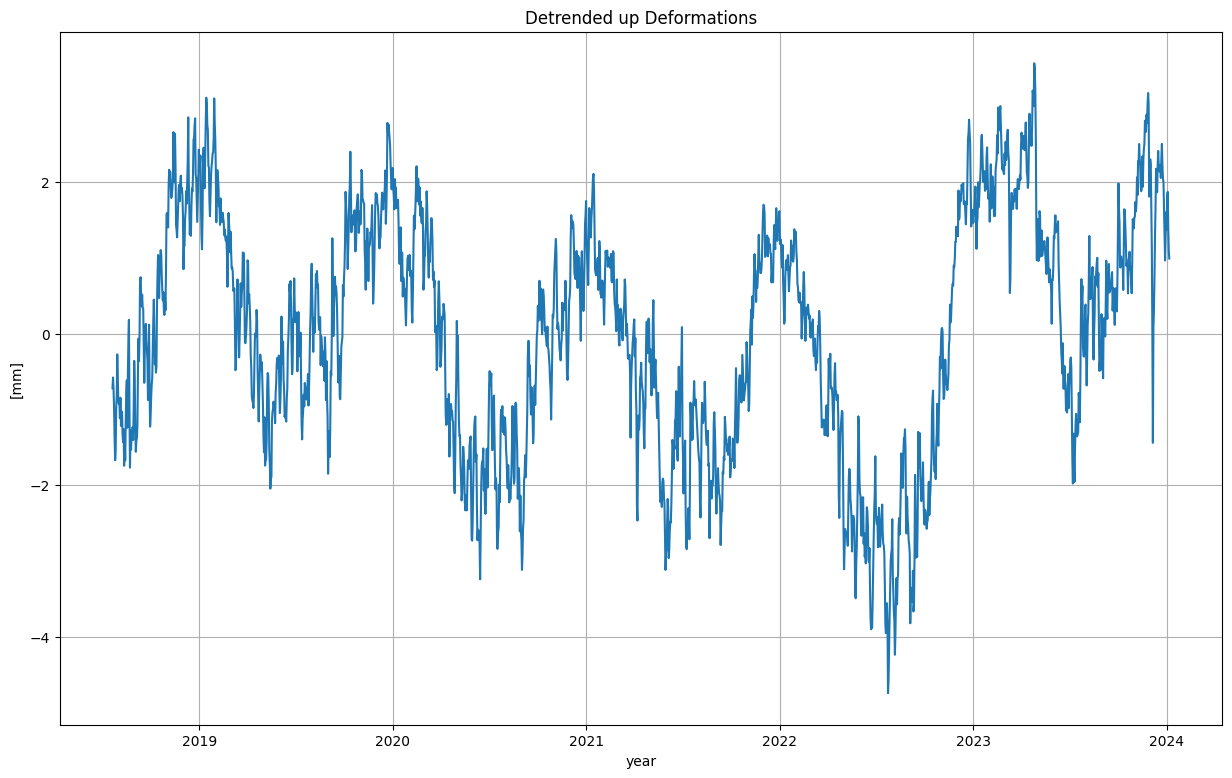

In [17]:
from scipy import signal
detrended_data = signal.detrend(data['Deformations Up'], axis=-1, type='linear', bp=0, overwrite_data=False)
plt.figure(figsize=(15,9))
plt.title('Detrended up Deformations')
plt.plot(data['Year'],detrended_data)
plt.ylabel('[mm]')
plt.xlabel('year')
plt.grid()

<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
/var/folders/9f/qj38cd3d5v37nszw4dsn87nr0000gn/T/ipykernel_29213/1207665872.py:4: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta$t [years]')


 time sample size 0.0027378507870707836
year with time sample size outlier: 5539    2021.566051
5544    2021.579740
Name: Year, dtype: float64
time sample size of outliers [0.00821355 0.00821355]


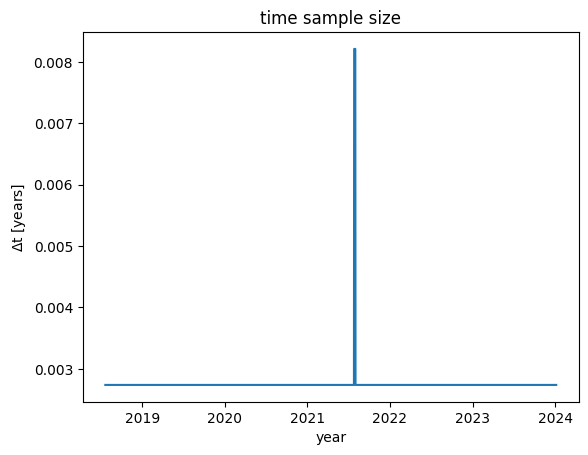

In [18]:
#check time sample spacing
gradient= np.gradient(data['Year'])
plt.plot(data['Year'], gradient)
plt.ylabel('$\Delta$t [years]')
plt.xlabel('year')
plt.title('time sample size')
index= np.where(gradient>0.004)
print(f' time sample size {gradient[10]}')
print(f'year with time sample size outlier: {data['Year'].iloc[index]}')
print(f'time sample size of outliers {gradient[index]}')

Text(0.5, 1.0, 'max peak at period 1.0 year')

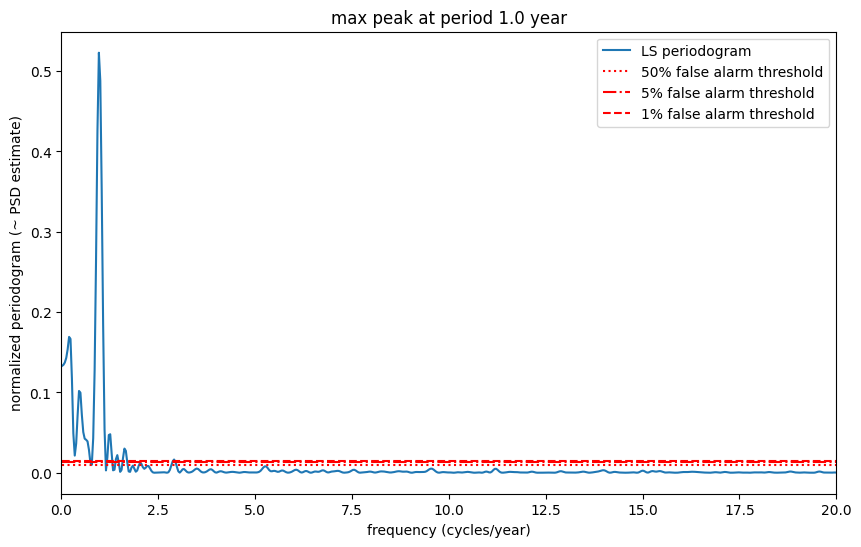

In [19]:
# perform a Lomb Scargle periodogram of the detrended data

from astropy.timeseries import LombScargle

LS = LombScargle(data['Year'], detrended_data)

frequency, power = LS.autopower(nyquist_factor=1)
plt.figure(figsize=(10,6))
plt.plot(frequency,power,label='LS periodogram')

# calculate levels of false alarm probabilities
false_alarm_probabilities=[0.5,0.05,0.01]
levels = LS.false_alarm_level(false_alarm_probabilities,method='baluev') # preferred options are "bootstrap" and "baluev", "naive" is unreliable

plt.plot(frequency,levels[0]*np.ones((frequency).shape),'r:',label='50% false alarm threshold')
plt.plot(frequency,levels[1]*np.ones((frequency).shape),'r-.',label='5% false alarm threshold ')
plt.plot(frequency,levels[2]*np.ones((frequency).shape),'r--',label='1% false alarm threshold')

plt.legend()
plt.xlabel('frequency (cycles/year)')
plt.xlim(0,20)
plt.ylabel('normalized periodogram (~ PSD estimate)')
plt.title('Lomb-Scargle periodogram of detrended time series')

freq_max = frequency[power.argmax()]
plt.title('max peak at period {} year'.format(round(1/freq_max,1)))

**Fitting the SSM to the time series alone:**

1. **Experiment no 1: Stochastic trend + white observation noise:** 
   1 - Random walk with constant drift 
    check state variance. if near zero -> use static trend
    2- Intergated random walk

2. **Experiment no 2: Stochastic trend (integrated random walk) + annual cycle  + white observation noise.** Based on the updated Lomb-Scargle periodogram for this case. 

3. **Experiment no 3: Stochastic trend (integrated random walk) + annual cycle + AR(1)**
ACF and PACF for order

## stochastic trend in the form of an random walk with constant drift + white noise

In [20]:
model_settings = {
     'irregular': True, 
     'level': True, 
     'stochastic_level': True, 
     'trend': True, 
     'stochastic_trend': False,
}

# ssm = state space model
ssm = sm.tsa.UnobservedComponents(data['Deformations Up'], **model_settings)

# print some information about the state space model
print(ssm.param_names)
print(ssm.state_names)

# number of observations needed to estimate initial state
n_obs_init = ssm.k_states - int(ssm._unused_state) - ssm.ar_order
display(n_obs_init)

# fit the state space model parameters and states
ssm_res = ssm.fit(method='powell', disp=True)

['sigma2.irregular', 'sigma2.level']
['level', 'trend']


/Users/isabelslingerland/opt/anaconda3/envs/pygmt/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2

Optimization terminated successfully.
         Current function value: 0.313907
         Iterations: 2
         Function evaluations: 54


In [21]:
# display fit results, hyperparameters, statistcial test results and information criteria
ssm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Unobserved Components Results                                
============================================================================================
Dep. Variable:                      Deformations Up   No. Observations:                 1992
Model:             local linear deterministic trend   Log Likelihood                -625.302
Date:                              Wed, 05 Jun 2024   AIC                           1254.605
Time:                                      16:27:12   BIC                           1265.797
Sample:                                           0   HQIC                          1258.715
                                             - 1992                                         
Covariance Type:                                opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.686e-09      0.002   8.49e-07      1.000      -0.004       0.004
sigma2.level         0.1093      0.005     23.721      0.000       0.100       0.118
===================================================================================
Ljung-Box (L1) (Q):                  26.40   Jarque-Bera (JB):                67.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.17
Prob(H) (two-sided):                  1.00   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
fig = ssm_res.plot_components(figsize=(12, 18), alpha=alpha)
for ax in fig.get_axes():
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set(title=None)
    
    # Set x-axis labels to match the Year data
    ax.set_xticks(np.linspace(0, len(data['Year']) - 1, num=7))
    ax.set_xticklabels([str(int(year)) for year in np.linspace(2018.551677, 2024.013689, num=7).round(1)])
    ax.set_xlabel('Year')
    ax.set_ylabel('Deformation [mm]')
fig.suptitle("Model Components: Random Walk with Constant Drift", y=0.92)
plt.show()

NameError: name 'alpha' is not defined

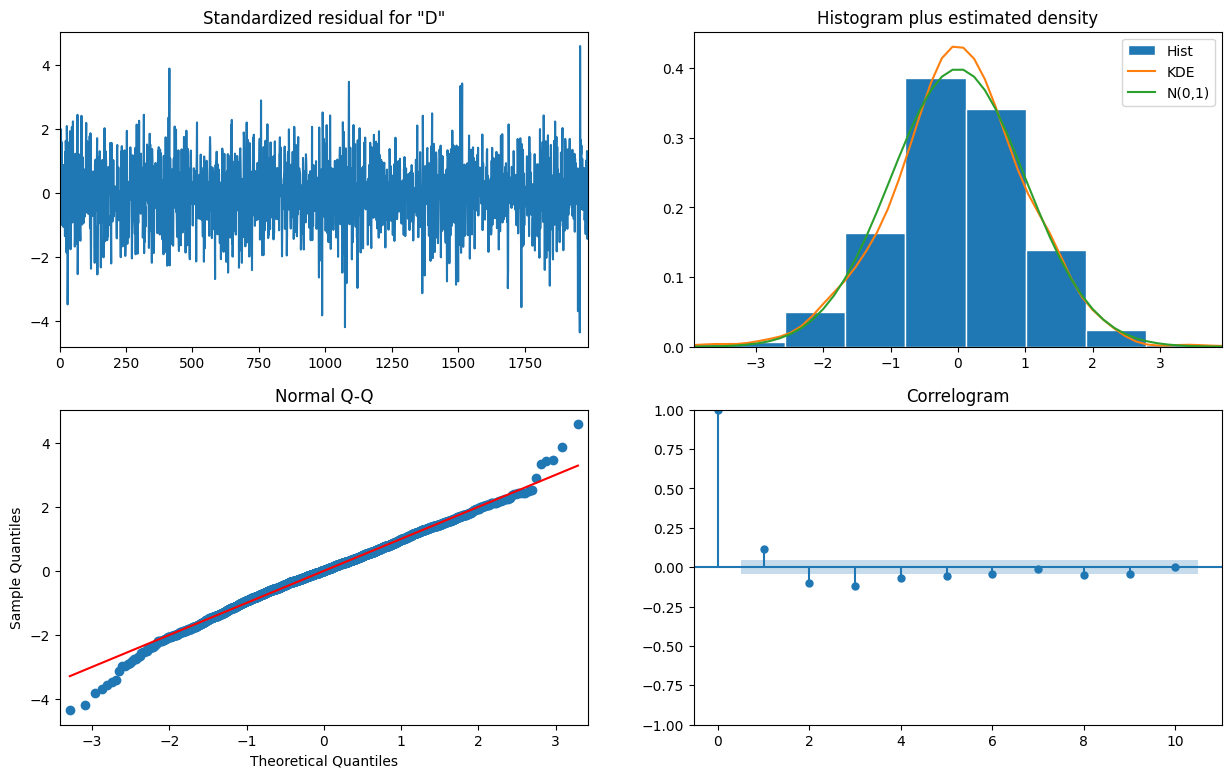

In [23]:
# plot states and their uncertainties
# fig = ssm_res.plot_components(legend_loc='lower right', figsize=(9, 18));


# plot diagnostics
dummy = ssm_res.plot_diagnostics(figsize=(15, 9))

### stochastic trend in the form of an integrated random walk + white noise

In [24]:
model_settings = {
     'irregular': True, 
     'level': True, 
     'stochastic_level': False, 
     'trend': True, 
     'stochastic_trend': True,
}

# ssm = state space model
ssm = sm.tsa.UnobservedComponents(data['Deformations Up'], **model_settings)

# print some information about the state space model
print(ssm.param_names)
print(ssm.state_names)

# number of observations needed to estimate initial state
n_obs_init = ssm.k_states - int(ssm._unused_state) - ssm.ar_order
display(n_obs_init)

# fit the state space model parameters and states
ssm_res = ssm.fit(method='powell', disp=True)

['sigma2.irregular', 'sigma2.trend']
['level', 'trend']


/Users/isabelslingerland/opt/anaconda3/envs/pygmt/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2

Optimization terminated successfully.
         Current function value: 0.495347
         Iterations: 4
         Function evaluations: 115


In [25]:
# display fit results, hyperparameters, statistcial test results and information criteria
ssm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:        Deformations Up   No. Observations:                 1992
Model:                   smooth trend   Log Likelihood                -986.731
Date:                Wed, 05 Jun 2024   AIC                           1977.462
Time:                        16:27:17   BIC                           1988.654
Sample:                             0   HQIC                          1981.573
                               - 1992                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0327      0.001     27.667      0.000       0.030       0.035
sigma2.trend         0.0429      0.002     18.006      0.000       0.038       0.048
===================================================================================
Ljung-Box (L1) (Q):                  18.68   Jarque-Bera (JB):               138.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.04
Prob(H) (two-sided):                  0.94   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
fig = ssm_res.plot_components(figsize=(12, 18), alpha=alpha)
for ax in fig.get_axes():
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set(title=None)
    
    # Set x-axis labels to match the Year data
    ax.set_xticks(np.linspace(0, len(data['Year']) - 1, num=7))
    ax.set_xticklabels([str(int(year)) for year in np.linspace(2018.551677, 2024.013689, num=7).round(1)])
    ax.set_xlabel('Year')
    ax.set_ylabel('Deformation [mm]')
fig.suptitle("Model Components: Integrated random walk", y=0.92)

NameError: name 'alpha' is not defined

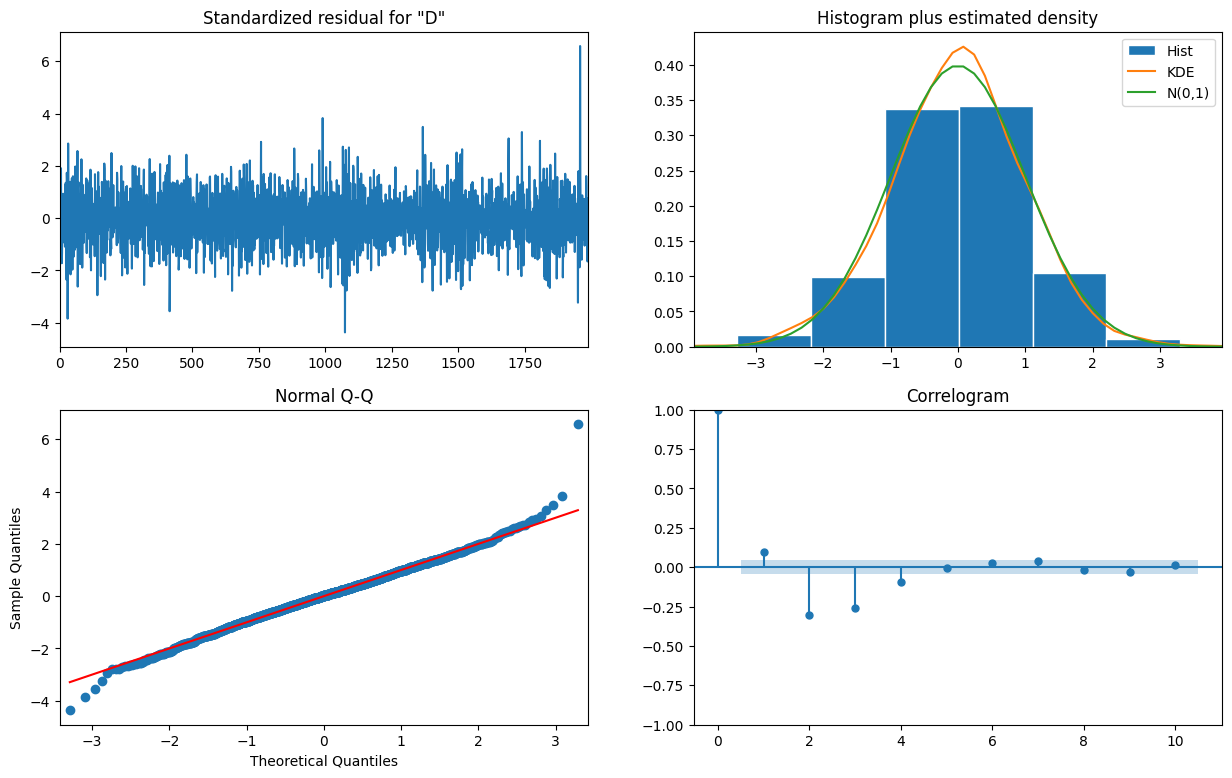

In [27]:
# plot states and their uncertainties
# fig = ssm_res.plot_components(legend_loc='lower right', figsize=(9, 18));


# plot diagnostics
dummy = ssm_res.plot_diagnostics(figsize=(15, 9))

## Integrated random walk + seasonal component

In [28]:
#find period of the signal
dt = np.mean(np.diff(data['Year']))
print(f'dt {dt} period {round(1/dt)} days')

dt 0.0027433512407476343 period 365 days


In [29]:
#stacastic trend + annual cycle

#frequency of the annual cycle
frequencies = [{'period': 365, 'harmonics': 1}]

# model settings
model_settings = {
     'irregular': True, 
     'level': True, 
     'stochastic_level': False, 
     'trend': True, 
     'stochastic_trend': True,
     'freq_seasonal': frequencies,
     'stochastic_freq_seasonal': [True]
}

# ssm = state space model
ssm = sm.tsa.UnobservedComponents(data['Deformations Up'], **model_settings)

# print some information about the state space model
print(ssm.param_names)
print(ssm.state_names)

# number of observations needed to estimate initial state
n_obs_init = ssm.k_states - int(ssm._unused_state) - ssm.ar_order
display(n_obs_init)

# fit the state space model parameters and states
ssm_res = ssm.fit(method='powell', disp=True)

['sigma2.irregular', 'sigma2.trend', 'sigma2.freq_seasonal_365(1)']
['level', 'trend', 'freq_seasonal.0', 'freq_seasonal.1']


/Users/isabelslingerland/opt/anaconda3/envs/pygmt/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


4

Optimization terminated successfully.
         Current function value: 0.326787
         Iterations: 3
         Function evaluations: 162


In [30]:
# display fit results, hyperparameters, statistcial test results and information criteria
ssm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                 
==============================================================================================
Dep. Variable:                        Deformations Up   No. Observations:                 1992
Model:                                   smooth trend   Log Likelihood                -650.959
                   + stochastic freq_seasonal(365(1))   AIC                           1307.918
Date:                                Wed, 05 Jun 2024   BIC                           1324.702
Time:                                        16:27:23   HQIC                          1314.082
Sample:                                             0                                         
                                               - 1992                                         
Covariance Type:                                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
sigma2.irregular             4.244e-14      0.002   2.12e-11      1.000      -0.004       0.004
sigma2.trend                 2.367e-09   2.72e-08      0.087      0.931   -5.09e-08    5.57e-08
sigma2.freq_seasonal_365(1)     0.1089      0.005     22.918      0.000       0.100       0.118
===================================================================================
Ljung-Box (L1) (Q):                  24.05   Jarque-Bera (JB):                65.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.17
Prob(H) (two-sided):                  0.99   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/isabelslingerland/opt/anaconda3/envs/pygmt/lib/python3.12/site-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


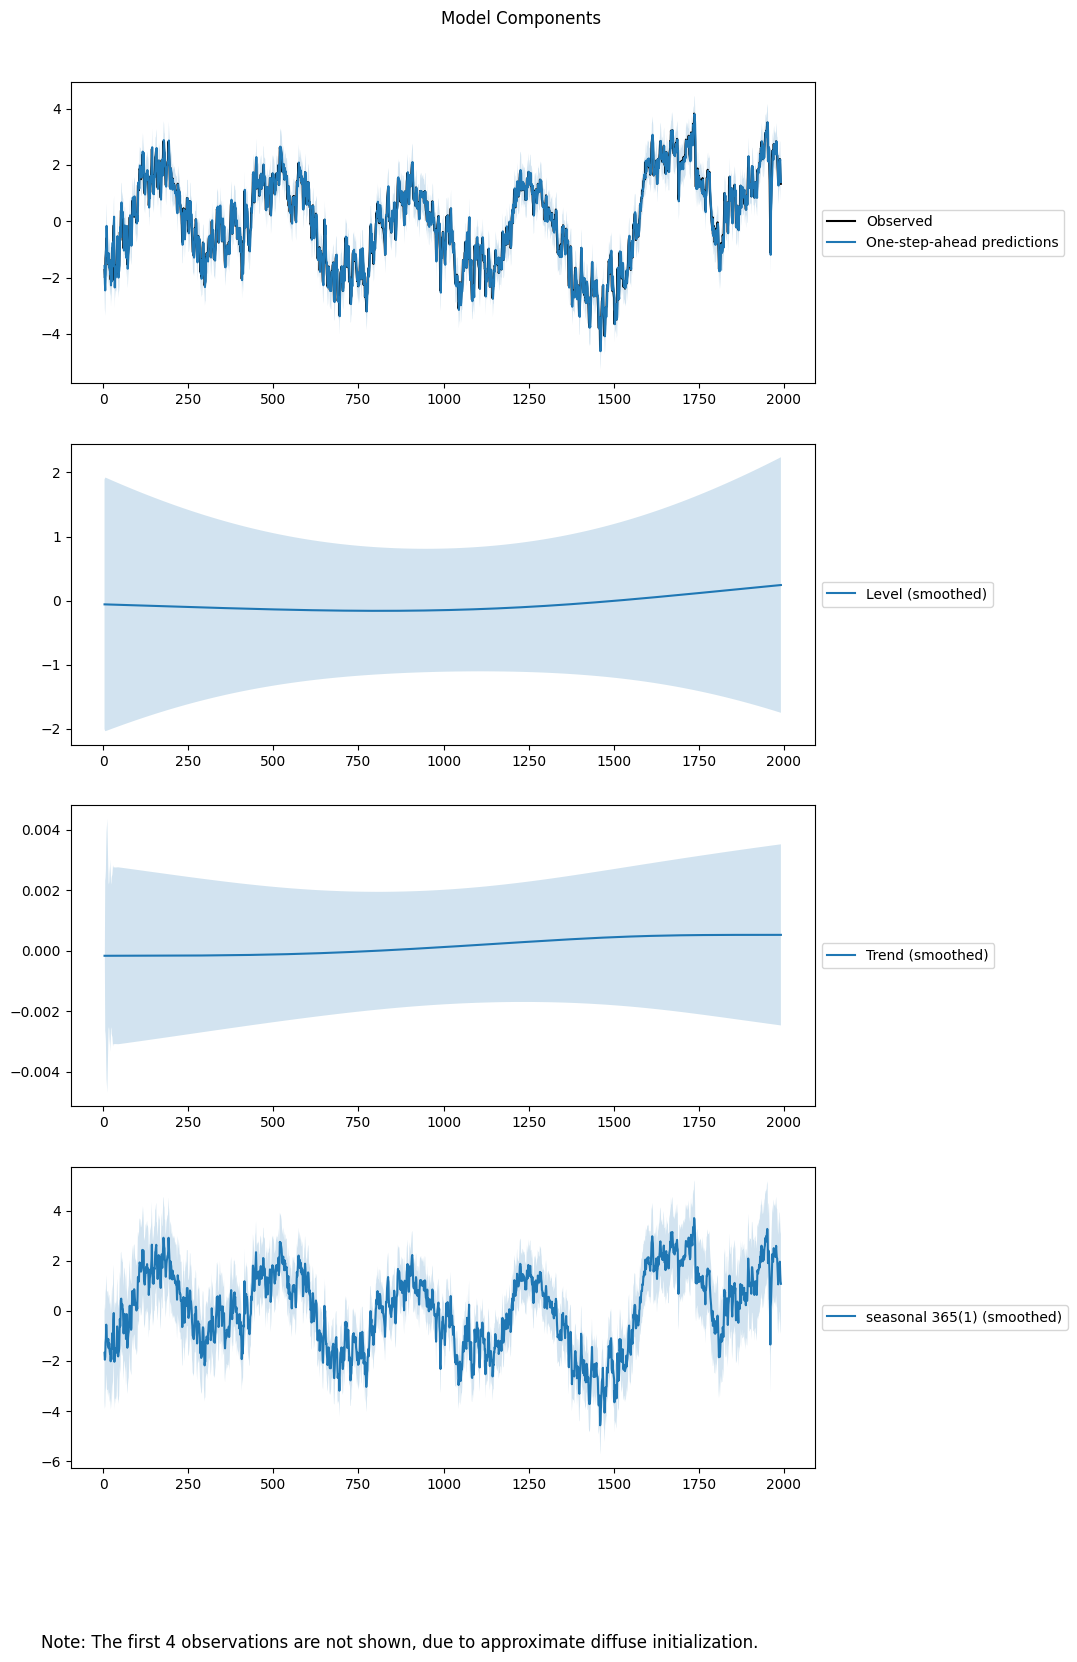

In [31]:
# fig = ssm_res.plot_components(legend_loc='lower right', figsize=(9, 18));
alpha = 0.05
fig = ssm_res.plot_components(figsize=(12, 18), alpha=alpha)
for ax in fig.get_axes():
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set(title=None)
fig.suptitle("Model Components", y=0.92);

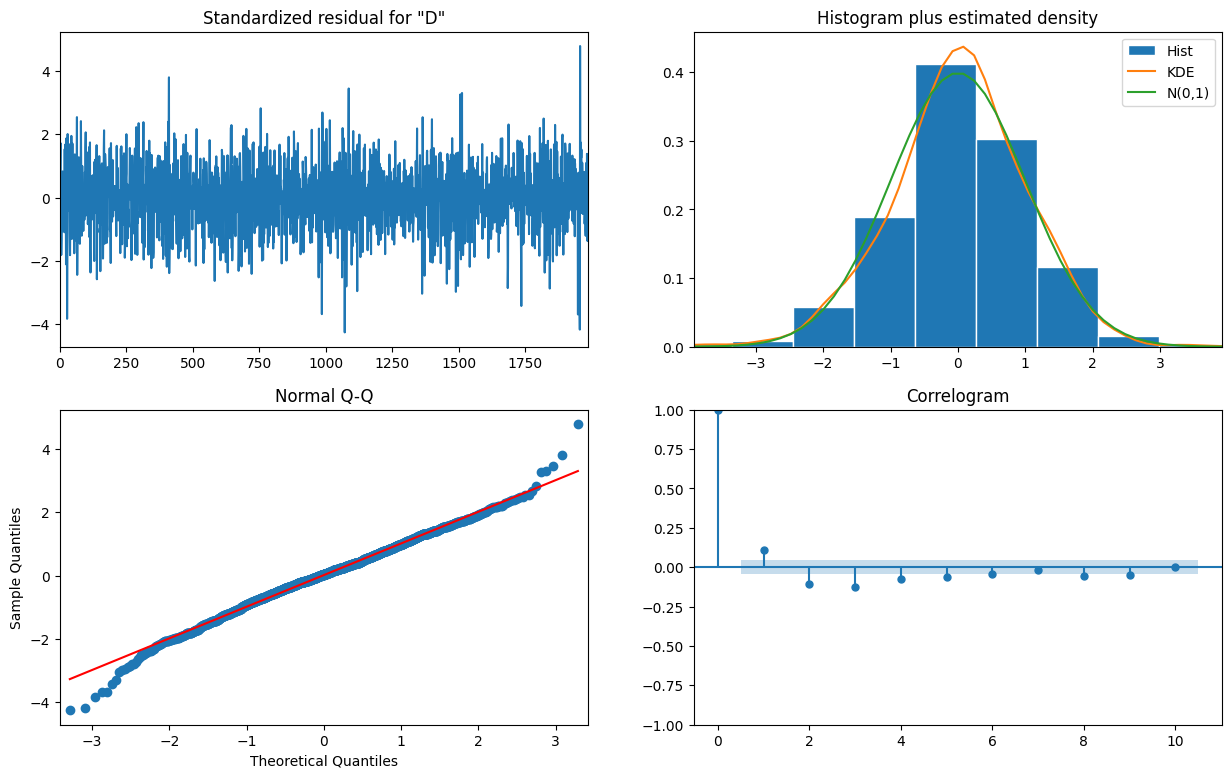

In [32]:
# plot diagnostics
dummy = ssm_res.plot_diagnostics(figsize=(15, 9))

## integrated walker +  seasonal component + AR

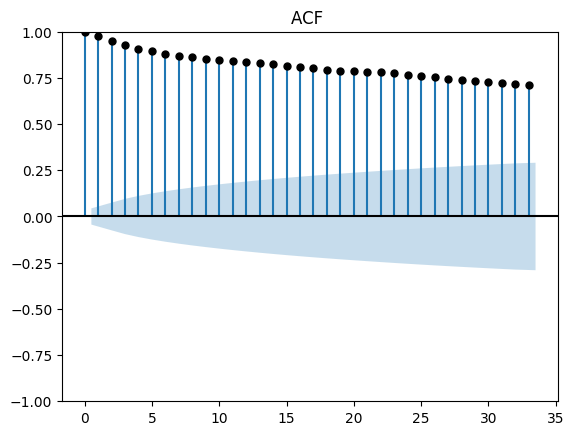

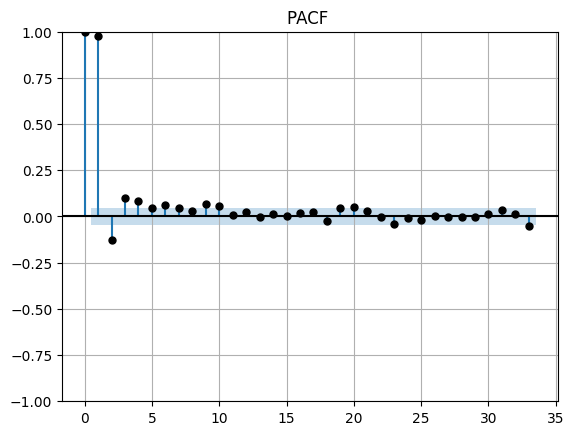

In [33]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
ACF = plot_acf(data['Deformations Up'], lags=None, alpha=0.05, title='ACF ', color='black')
PACF = plot_pacf(data['Deformations Up'], lags=None, alpha=0.05, title='PACF ', color='black')
plt.grid()

In [41]:
frequencies = [{'period': 365, 'harmonics': 1}]

model_settings = {
     'irregular': True, 
     'autoregressive': 1,
     'level': True, 
     'stochastic_level': False, 
     'trend': True, 
     'stochastic_trend': True,
     'freq_seasonal': frequencies,
     'stochastic_freq_seasonal': [True]
}

# ssm = state space model
ssm = sm.tsa.UnobservedComponents(data['Deformations Up'], **model_settings)

# print some information about the state space model
print(ssm.param_names)
print(ssm.state_names)

# number of observations needed to estimate initial state
n_obs_init = ssm.k_states - int(ssm._unused_state) - ssm.ar_order
display(n_obs_init)

# fit the state space model parameters and states
ssm_res = ssm.fit(method='powell', disp=True)

# Extract the fitted values
fitted_values = ssm_res.fittedvalues



['sigma2.irregular', 'sigma2.trend', 'sigma2.freq_seasonal_365(1)', 'sigma2.ar', 'ar.L1']
['level', 'trend', 'freq_seasonal.0', 'freq_seasonal.1', 'ar.L1']


/Users/isabelslingerland/opt/anaconda3/envs/pygmt/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


4

Optimization terminated successfully.
         Current function value: 0.302065
         Iterations: 9
         Function evaluations: 591


In [42]:
ssm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                 
==============================================================================================
Dep. Variable:                        Deformations Up   No. Observations:                 1992
Model:                                   smooth trend   Log Likelihood                -601.714
                   + stochastic freq_seasonal(365(1))   AIC                           1213.427
                                              + AR(1)   BIC                           1241.402
Date:                                Wed, 05 Jun 2024   HQIC                          1223.702
Time:                                        17:59:41                                         
Sample:                                             0                                         
                                               - 1992                                         
Covariance Type:                                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
sigma2.irregular             2.243e-10      0.003   7.98e-08      1.000      -0.006       0.006
sigma2.trend                 5.045e-07   3.06e-07      1.648      0.099   -9.57e-08     1.1e-06
sigma2.freq_seasonal_365(1)     0.0001      0.000      0.789      0.430      -0.000       0.000
sigma2.ar                       0.1025      0.005     21.018      0.000       0.093       0.112
ar.L1                           0.8825      0.014     64.783      0.000       0.856       0.909
===================================================================================
Ljung-Box (L1) (Q):                  50.19   Jarque-Bera (JB):                97.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.27
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/isabelslingerland/opt/anaconda3/envs/pygmt/lib/python3.12/site-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


Text(0.5, 0.92, 'Model Components stocastic trend + Seasonal + AR(1) ')

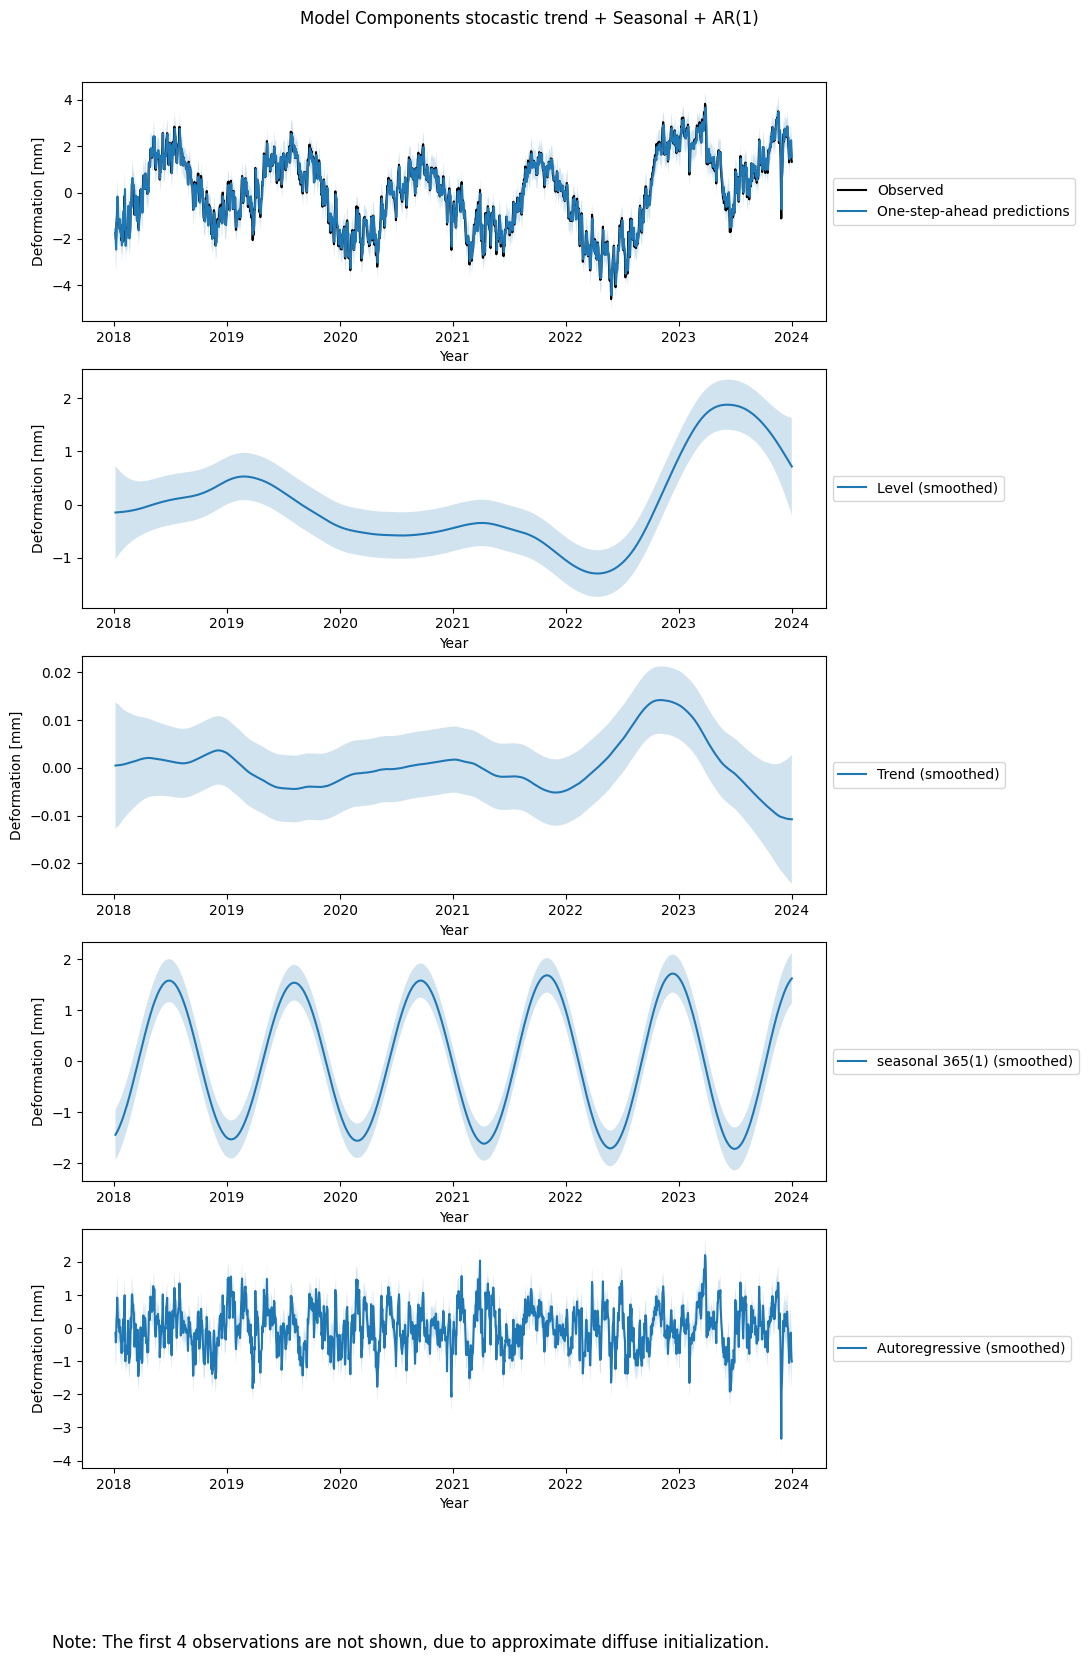

In [43]:

# fig = ssm_res.plot_components(legend_loc='lower right', figsize=(9, 18));
alpha = 0.05
fig = ssm_res.plot_components(figsize=(12, 18), alpha=alpha)
for ax in fig.get_axes():
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set(title=None)
    
    # Set x-axis labels to match the Year data
    ax.set_xticks(np.linspace(0, len(data['Year']) - 1, num=7))
    ax.set_xticklabels([str(int(year)) for year in np.linspace(2018.551677, 2024.013689, num=7).round(1)])
    ax.set_xlabel('Year')
    ax.set_ylabel('Deformation [mm]')
fig.suptitle("Model Components stocastic trend + Seasonal + AR(1) ", y=0.92)


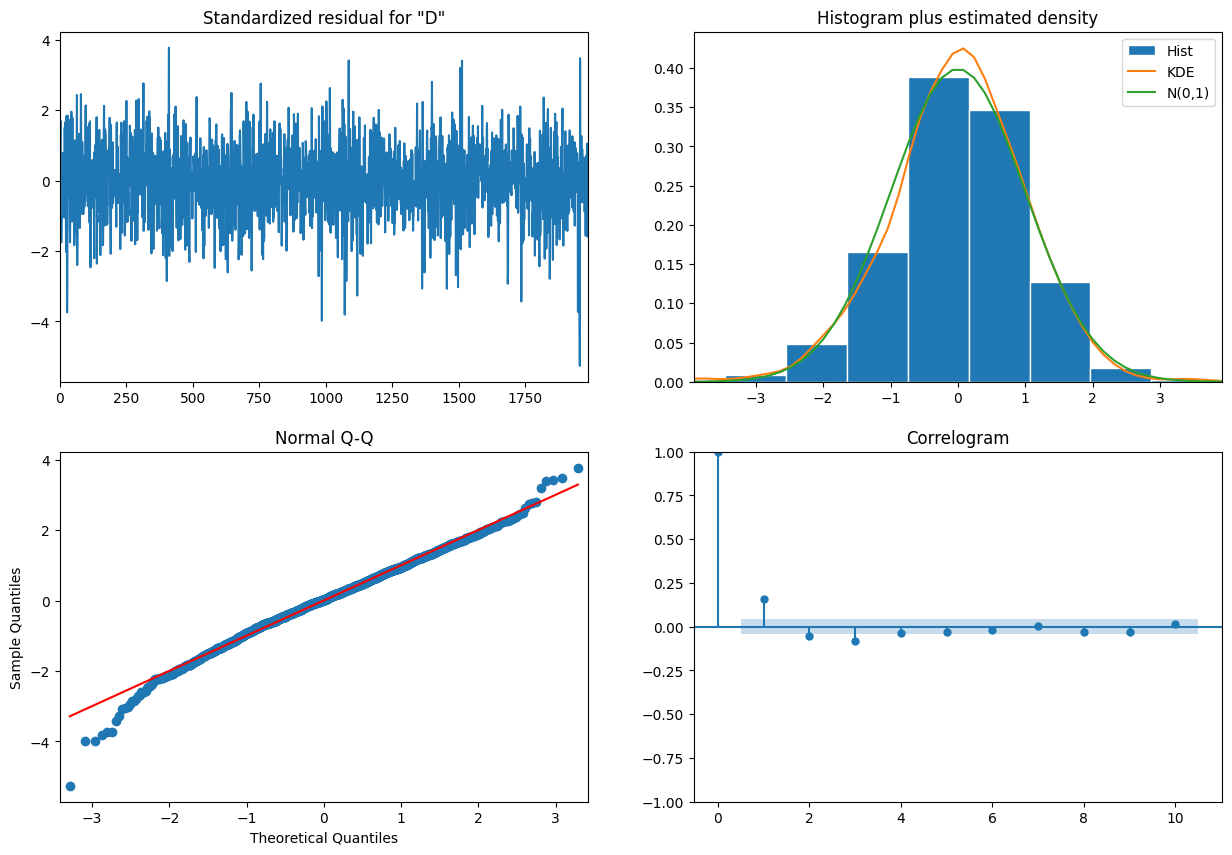

In [44]:
dummy = ssm_res.plot_diagnostics(figsize=(15, 10))

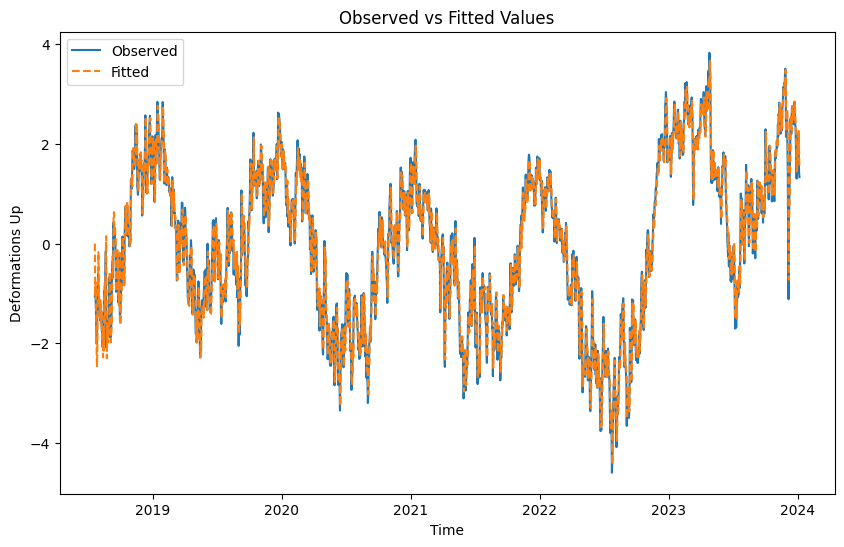

In [45]:
# Extract the fitted values
fitted_values = ssm_res.fittedvalues

plt.figure(figsize=(10, 6))
plt.plot(data['Year'],data['Deformations Up'], label='Observed')
plt.plot(data['Year'],fitted_values, label='Fitted', linestyle='--')
plt.legend()
plt.title('Observed vs Fitted Values')
plt.xlabel('Time')
plt.ylabel('Deformations Up')
plt.show()

Observation equation covariance matrix (measurement noise):
 [[[2.24312827e-10]]]
State equation covariance matrix (process noise):
 [[[5.04516203e-07]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [1.18928141e-04]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [1.18928141e-04]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [1.02537947e-01]]]
Standard deviation (sigma) of the residuals: 0.3292609296798


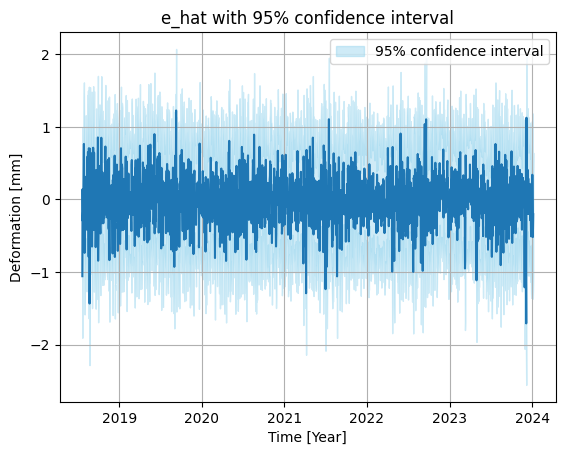

In [46]:
obs_cov_matrix = ssm_res.filter_results.obs_cov
print("Observation equation covariance matrix (measurement noise):\n", obs_cov_matrix)

state_cov_matrix = ssm_res.filter_results.state_cov

print("State equation covariance matrix (process noise):\n", state_cov_matrix)

residuals = ssm_res.resid
sigma = np.std(residuals)
print("Standard deviation (sigma) of the residuals:", sigma)

plt.plot(data['Year'], residuals)
ehat_int = norm.ppf(.995, scale = sigma )
ehatplus = residuals + ehat_int
ehatmin = residuals - ehat_int

plt.fill_between(data['Year'], ehatplus, ehatmin, color='skyblue', alpha=0.4, label='95% confidence interval')
plt.legend()
plt.title(f'e_hat with 95% confidence interval')
plt.xlabel('Time [Year]')
plt.ylabel('Deformation [mm]')
plt.grid()

## Check stationarity


In [50]:
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

adf_test(fitted_values)

Results of Dickey-Fuller Test:
Test Statistic                   -2.847094
p-value                           0.051855
#Lags Used                        9.000000
Number of Observations Used    1982.000000
Critical Value (1%)              -3.433654
Critical Value (5%)              -2.862999
Critical Value (10%)             -2.567547
dtype: float64


## Looking into the noise

Im gonna look int Power-law noise (linked to PSD) which is a long memory noise process



In [40]:
def log_likelihood(Qyy, ehat):
    """
    This function computes the Log-Likelihood value for a given covariance matrix and residual vector.
    INPUT:
        Qyy: mxm covariance matrix of observations (time series)
        ehat: least squares estimate of residulas
    OUTPUT:
        log_like: Log-Likelihood value
    """
    m = Qyy.shape[0]
    # compute eigenvalues of Qyy
    lambda_vals = linalg.eigvals(Qyy)
    # compute sum-of-log of eigenvalues
    log_det = np.sum(np.log(lambda_vals))
    # compute Qyy_inv * ehat
    inv_Qyy_ehat = linalg.solve(Qyy, ehat)
    # compute log-likelihood
    log_like = -m/2*np.log(2*np.pi) - 1/2*log_det - 1/2*ehat.T @ inv_Qyy_ehat
    return log_like

In [41]:
def ls_vce(A, y, Qcf, sig0):
    """ 
    This function implements the LS-VCE method presented in:
    Teunissen, P.J.G., A.R. Amiri-Simkooei (2008). Least-squares variance component estimation, Journal of Geodesy, 82 (2): 65-82

    Input:
        A: the initial design matrix
        y: the vector of observations
        Qcf: mxm cofactor matrices Qcf[:,:,i], i=1,...,p. For example Q1 = Qcf[:,:,1].
        sig0: initial values of variance components, usually sig0=[1,...,1]
    Output:
        Sighat: final estimates of variance components
        Qs: covariance matrix of Sighat
        Qyy: final covariance matrix of observation vector y
        AllSighat: All variance components computed in different iterations, finally converged to Sighat 
    """
    # number of variance components
    p = np.size(Qcf,2)
    # size of design mtrix, m: number of rows (observations), and n: number of columns (unknowns)
    m, n = A.shape
    # initialze Sighat as sig0
    Sighat = sig0
    sig0 = Sighat+1
    # iteration counter is set to 0
    IT = 0
    # initialize an empty array AllSighat (all estimated variances in different iterations)
    AllSighat = np.array([]) 
    # a loop, which checks if the conversion of variances has happened
    while np.max(np.abs(Sighat-sig0)) > 1e-10 and IT < 10:  # change the threshold to see the effect (max 10 iterations)
        sig0 = Sighat
        # initialize Qyy
        Qyy = np.zeros((m, m))
        # given sig0, update Qyy
        for i in range(p):
             Qyy += sig0[i]*Qcf[:, :, i]
        # invert Qyy
        Qyinv = linalg.inv(Qyy)
        # compute the projector Pao
        Pao = np.eye(m) - A.dot(linalg.inv(A.T.dot(Qyinv).dot(A))).dot(A.T).dot(Qyinv)
        # compute the product of Qyinv and Pao
        QyinvP = Qyinv.dot(Pao)
        # compute the least squares residuals
        ehat = Pao.dot(y)
        Help = Qyinv.dot(ehat)
        # initialize l amd N
        l = np.zeros((p))
        N = np.zeros((p, p))
        # compute l (px1) and N (pxp)
        for i in range(p):
            l[i] = 0.5*(Help.T.dot(Qcf[:, :, i]).dot(Help))
            for j in range(i, p):
                N[i, j] = 0.5*np.trace(QyinvP.dot(Qcf[:, :, i]).dot(QyinvP).dot(Qcf[:, :, j]))
                N[j, i] = N[i, j]
        # we can estimate Sighat = inv(N)*l, but this has the risk to give negative variances
        # Sighat = linalg.inv(N).dot(l)
        # Qs = linalg.inv(N)
        # alternative is to use non-negative least squares (NNLS) to guarantee positive variances
        Sighat, Qs = nnls_v(N, l)  
        AllSighat = np.concatenate((AllSighat, Sighat)) # concatenate the subvector with AllSighat
        IT += 1
        print('Iteration %d, Estimated variances: %s' % (IT, Sighat)) 
    AllSighat = np.reshape(AllSighat, (p, IT), order='F') # reshape AllSighat into a pxIT matrix (column-wise)
    
    return Sighat, Qs, Qyy, AllSighat

In [42]:
def nnls_v(N, L):
    """ 
    This function implements the Non-Negative LS-VCE (NNLS-VCE) method (not part of LO, we just use it).
    It solves the non-negative least-squares problem: min = 0.5*s^T*N*s + L^t*s subject to s>=0
    Without the non-negativity constraints the least-squares solution is s = inv(N)*L.
    But nnls_v poses the constraints s>=0 to obtain non-negative unknowns s. For further information refer to:
    Non-negative least-squares variance component estimation with application to GPS time series, AR Amiri-Simkooei, Journal of Geodesy 90, 451-466
    Input:
        N: the normal pxp matrix
        L: the px1 vector

    Output:
        Sighat: final estimates of variance components Sighat>=0
        Qs: covariance matrix of Sighat
    """
    p = len(L)
    mu0 = -L.copy()
    s0 = np.zeros((p))
    stest = s0 + 1
    s = s0.copy()
    while linalg.norm(s-stest) > 1e-10:
        for k in range(p):
            s[k] = max(0, s0[k] - mu0[k] / N[k, k])
            mu0 = mu0 + (s[k] - s0[k]) * N[:, k]
        stest = s0.copy()
        s0 = s.copy()
    index = np.where(s == 0)[0]
    Ct = np.zeros((len(index), p))
    k1, k2 = Ct.shape
    for i in range(len(index)):
        Ct[i, index[i]] = 1
    C = Ct.T
    Ni = linalg.inv(N)
    if k1 > 0:
        Pco = np.eye(p) - C @ linalg.inv(Ct @ Ni @ C) @ Ct @ Ni
    else:
        Pco = np.eye(p)
    Qs = Ni @ Pco
    Sighat = s.copy()
    return Sighat, Qs


In [43]:
def pl_cofactor(kappa, time, dt):
    """
    This function computes the power-law cofactor matrix for a given spectral index kappa.
    INPUT:
        kappa: spectral index in the renge of [0-2]
        time: time instances of the time series
        dt: sampling interval
    OUTPUT:
        Q: cofactor matrix Q_pl(kappa)  
    """
    # change time to integer numbers
    time = np.round(time/dt).astype(int)
    # shift it to have t(0) = 1
    t = time - time[0] + 1

    m = t[-1]
  
    H = np.zeros((m,1))
    print(f'H {H.shape}')
    H[0] = 1
    for i in range(1, m):
        # make H[i]
        H[i] = H[i-1] * (kappa/2 + i - 1)/i
    # make a toeplitz matrix and then consider only its upper triangular
    U = np.triu(linalg.toeplitz(H))
   
    # find possible gaps in data (if data is not equally-spaced)
    # index refers to indices where we have data
    index = np.isin(np.arange(1, m+1), t)
  
    # make the final U, removing gaps
    U = U[:, index]
   
    Q = np.power(dt, kappa/2) * U.T @ U
  
    return Q

In [44]:
# The description is given above
time = data['Year'].values
# time series observations
y = data['Deformations Up'].values # N or E
m = len(y)
print(f' m{y.size}')
# sampling interval
dt = 1/365.2425
# design matrix based on y(t) = y0 + rt + e(t) 
A = np.ones((m,4))
A[:,1] = time
A[:,2] = np.cos(2*np.pi*dt*time)
A[:,3] = np.sin(2*np.pi*dt*time)
m, n = A.shape

# making cofactor matrix assuming only white noise: Qyy=sigma_w^2*I (only one variance component)
Qcf = np.zeros((m, m, 1))
Qcf[:,:,0] = np.eye(m,m) 
# or alternatively you can use pl_cofactor with kappa=0
# Qcf[:,:,0] = pl_cofactor(0, time, dt)
# initilize the variance component (only one)
sig0 = np.array([1])
# apply LS-VCE to estimate the only variance and Qyy
Sighat, Qs, Qyy, AllSighat = ls_vce(A, y, Qcf, sig0)
Qyyi = linalg.inv(Qyy)
# BLUE estimate of x
xhat = linalg.inv(A.T @ Qyyi @ A) @ A.T @ Qyyi @ y;
# BLUE estimate of y
yhat = A @ xhat;                         
# BLUE estimate of e (residuals)
ehat = y - yhat;
# compute Log-Likelihood for white-noise model
log_like = log_likelihood(Qyy, ehat)
print('Log-Likelihood of white noise = ',log_like)

# making cofactor matrices assuming white noise + power-law noise: Qyy=sigma_w^2*I+sigma_pl^2*Qpl
Qcf = np.zeros((m, m, 2))
print(f'Qcf{Qcf.shape}')
# white noise part (Q1)
Qcf[:,:,0] = pl_cofactor(0, time, dt)
# set values for kappa
kappa = np.arange(0.4, 2.8, 0.4)
# initialize log-likelihoods
log_like = np.zeros((len(kappa),1))
for i in range(len(kappa)):
    print('\nKappa = ',kappa[i])
    # make power-law cofactor matrix (Q2)
    Qcf[:,:,1] = pl_cofactor(kappa[i], time, dt)    
    # initilize variance components
    sig0 = np.array([1,0])
    # apply LS-VCE to estimate the two variances
    Sighat, Qs, Qyy, AllSighat = ls_vce(A, y, Qcf, sig0)
    Qyyi = linalg.inv(Qyy)
    # BLUE estimate of x
    xhat = linalg.inv(A.T @ Qyyi @ A) @ A.T @ Qyyi @ y;
    # BLUE estimate of y
    yhat = A @ xhat;                         
    # BLUE estimate of e (residuals)
    ehat = y - yhat;
    # compute Log-Likelihood for white-noise + power-law noise model
    log_like[i] = log_likelihood(Qyy, ehat)
    print('Log-Likelihood = ', log_like[i])

 m1992
Iteration 1, Estimated variances: [1.95920107]
Iteration 2, Estimated variances: [1.99779494]
Iteration 3, Estimated variances: [1.96770538]
Iteration 4, Estimated variances: [2.05653591]
Iteration 5, Estimated variances: [68.65651217]
Iteration 6, Estimated variances: [1.97468692]
Iteration 7, Estimated variances: [3.55942141]
Iteration 8, Estimated variances: [1.98736942]
Iteration 9, Estimated variances: [1.98995059]
Iteration 10, Estimated variances: [2.06009346]
Log-Likelihood of white noise =  (-3545.3091489259978+0j)
Qcf(1992, 1992, 2)
H (1996, 1)

Kappa =  0.4
H (1996, 1)
Iteration 1, Estimated variances: [ 0.         19.45627578]
Iteration 2, Estimated variances: [0.         1.71562186]
Iteration 3, Estimated variances: [0.         1.71562167]
Iteration 4, Estimated variances: [0.         1.71566942]
Iteration 5, Estimated variances: [0.        1.7156094]
Iteration 6, Estimated variances: [0.       1.715624]
Iteration 7, Estimated variances: [0.         1.71568649]
Iter

/var/folders/9f/qj38cd3d5v37nszw4dsn87nr0000gn/T/ipykernel_21650/1872290774.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  log_like[i] = log_likelihood(Qyy, ehat)


Log-Likelihood =  [-2186.84731839]

Kappa =  0.8
H (1996, 1)
Iteration 1, Estimated variances: [ 0.         39.73279906]
Iteration 2, Estimated variances: [0.        2.2526455]
Iteration 3, Estimated variances: [0.         2.25265358]
Iteration 4, Estimated variances: [0.         2.25268185]
Iteration 5, Estimated variances: [0.         2.25256551]
Iteration 6, Estimated variances: [0.         2.25269013]
Iteration 7, Estimated variances: [0.         2.25259517]
Iteration 8, Estimated variances: [0.         2.25278734]
Iteration 9, Estimated variances: [0.         2.25268139]
Iteration 10, Estimated variances: [0.         2.25259679]
Log-Likelihood =  [-1282.7772919]

Kappa =  1.2000000000000002
H (1996, 1)
Iteration 1, Estimated variances: [ 0.         21.41441659]
Iteration 2, Estimated variances: [0.         4.63739375]
Iteration 3, Estimated variances: [0.         4.63864515]
Iteration 4, Estimated variances: [0.         4.63929448]
Iteration 5, Estimated variances: [0.         4.6

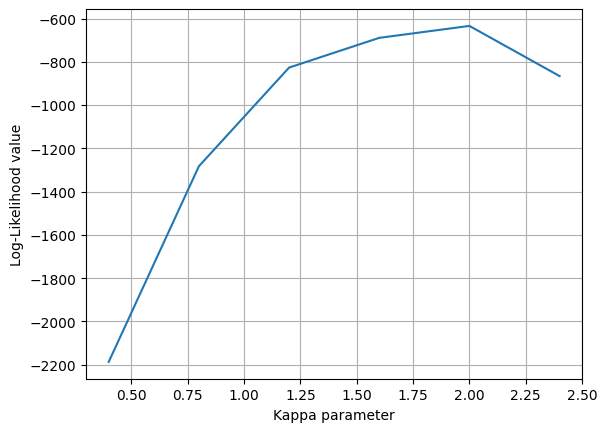

In [45]:
# plot Log-Likelihoods vs. kappa. determine optimal value for kappa, providing the max log-likelihood
plt.plot(kappa, log_like)
plt.xlabel('Kappa parameter')
plt.ylabel('Log-Likelihood value')
plt.grid()


In [46]:
# making cofactor matrices assuming white noise + power-law noise: Qyy=sigma_w^2*I+sigma_pl^2*Qpl
Qcf = np.zeros((m, m, 2))
# white noise part (Q1)
Qcf[:,:,0] = pl_cofactor(0, time, dt)
# the value that gives the maximum value for log_like
kappa_optimal = 2
# power-law cofactor matrix (Q2)
Qcf[:,:,1] = pl_cofactor(kappa_optimal, time, dt)    
# initilize variance components
sig0 = np.array([1,0])
# apply LS-VCE to estimate the two variances and therefore the final Qyy
Sighat, Qs, Qyy, AllSighat = ls_vce(A, y, Qcf, sig0)

H (1996, 1)
H (1996, 1)
Iteration 1, Estimated variances: [1.78592766 0.97670723]
Iteration 2, Estimated variances: [ 0.08148548 15.48279182]
Iteration 3, Estimated variances: [ 0.04639949 35.5680723 ]
Iteration 4, Estimated variances: [ 0.07978824 56.62859458]
Iteration 5, Estimated variances: [ 0.         42.47540773]
Iteration 6, Estimated variances: [2.33850368e-02 5.61624433e+01]
Iteration 7, Estimated variances: [ 0.07360378 49.01049529]
Iteration 8, Estimated variances: [1.66353690e-04 4.25372231e+01]
Iteration 9, Estimated variances: [ 0.         46.55065945]
Iteration 10, Estimated variances: [4.52037920e-03 4.72184986e+01]


## Line of Sight

we use the east north up components to compute the line of sight which we can use for the Insar data

In [47]:
def lineofsight(omega, alpha_d, d_e, d_n, d_u):
    """
    Computes the line-of-sight deformation.

    Parameters:
    omega (float): The incidence angle (in radians).
    alpha_d (float): The angle between the north and the range (in radians).
    d_e (float): The deformation component for east deformation.
    d_n (float): The deformation component for north deformation.
    d_u (float): The deformation component for up deformation.

    Returns:
    float: The dot product of the line-of-sight vector and the deformation vector.
    """
    A = np.array([np.sin(omega) * np.sin(alpha_d), np.sin(omega) * np.cos(alpha_d), np.cos(omega)])
    B = np.array([d_e, d_n, d_u])
    return np.dot(A, B)

print(updisplacements.shape)
print(northdisplacements.shape)
print(eastdisplacements.shape)  

#ascending satelite  angle incidence = 43.11 angle between north and range = 260.70
lof= np.zeros(updisplacements.size)
for i in range(updisplacements.size):
    lof[i]= lineofsight(np.radians(43.11), np.radians(260.70), eastdisplacements[i], northdisplacements[i], updisplacements[i])

#print(np.array([np.sin(43.11) * np.sin(260.70), np.sin(43.11) * np.cos(260.70), np.cos(43.11)]))

(6434,)
(6434,)
(6434,)


Text(0.5, 1.0, 'Line of sight [from GNSS station RDN1]')

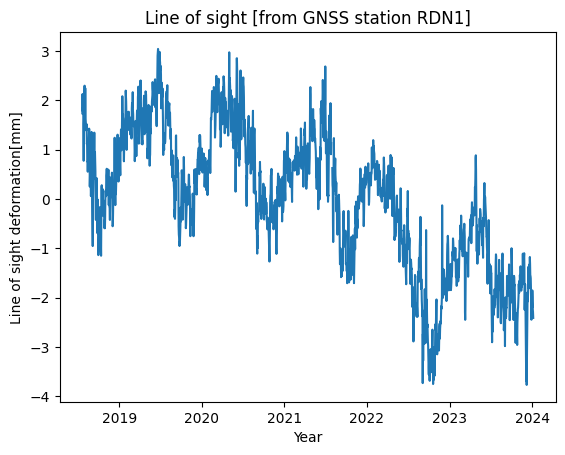

In [48]:
plt.plot(epochDyear, lof)
plt.xlabel('Year')
plt.ylabel('Line of sight deformation[mm]')
plt.title('Line of sight [from GNSS station RDN1]')


In [49]:
def get_vertical(lof, omega, alpha_d, d_e, d_n):
    """
    Computes the vertical deformation.

    Parameters:
    lof (float): The line-of-sight deformation.
    omega (float): The incidence angle (in radians).
    alpha_d (float): The angle between the north and the range (in radians).
    d_e (float): The deformation component for east deformation.
    d_n (float): The deformation component for north deformation.

    Returns:
    float: The vertical deformation.
    """
    return (lof - (d_e* np.sin(omega) * np.sin(alpha_d)) - (d_n*np.sin(omega) * np.cos(alpha_d))) / np.cos(omega)
    

vertical = get_vertical(lof, np.radians(43.11), np.radians(260.70), eastdisplacements, northdisplacements)

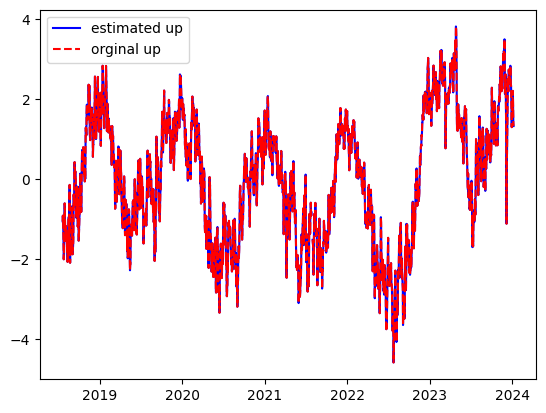

Text(0.5, 1.0, 'residuals')

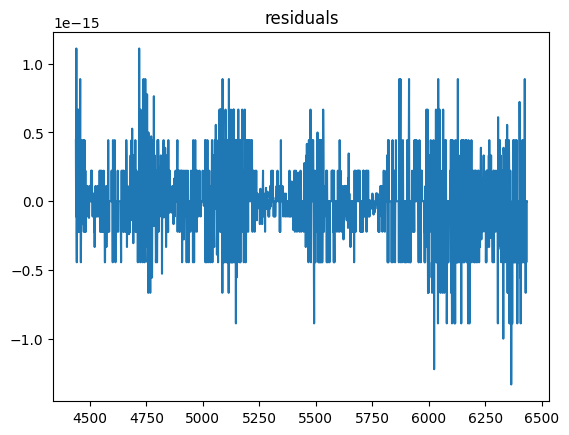

In [50]:
plt.plot(epochDyear, vertical, 'b' , label='estimated up')
plt.plot(epochDyear, updisplacements, 'r--', label='orginal up')
plt.legend()
plt.show()
plt.plot(vertical-updisplacements)
plt.title('residuals')

In [51]:
plt.plot

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>